# UE22CS342AA2: Data Analytics - Worksheet 3b
# ARIMAX, SARIMAX and LSTMs

Designed by Anshul Ranjan, Dept.of CSE - itsanshulranjan@gmail.com

## Student Details

• Name: Jananii Ramesh

• SRN: PES2UG22CS906

• Section: A

In the previous worksheet, we experimented with ARIMA models. However, one caveat of ARIMA (or similar models), is that it takes only the target variable into consideration, according to the timestamp. In essence, it derives the relationship between the current target variable values and the past variable values.

However, what if we have some other external factors affecting the target values?
This is where *ARIMAX* (AutoRegressive Integrated Moving Average with eXogenous variables) steps in!

ARIMAX extends the capabilities of ARIMA by incorporating external factors or exogenous variables that influence the time series data. It's the bridge that connects the simplicity of ARIMA with the complexity of real-world forecasting, allowing us to tackle more intricate and realistic forecasting challenges.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import warnings

warnings.filterwarnings("ignore")

## Loading the data

The data is already divided into Test and Train Set!!! But always remember Before you try to forecast anything split the dataset into train-test sets, as discussed in the previous worksheet. Remember, since we're dealing with time series data, we will not perform a random split! 

In [4]:
train = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")
test = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Test.csv", encoding = "unicode_escape")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            33750 non-null  object 
 1   is_holiday           43 non-null     object 
 2   air_pollution_index  33750 non-null  int64  
 3   humidity             33750 non-null  int64  
 4   wind_speed           33750 non-null  int64  
 5   wind_direction       33750 non-null  int64  
 6   visibility_in_miles  33750 non-null  int64  
 7   dew_point            33750 non-null  int64  
 8   temperature          33750 non-null  float64
 9   rain_p_h             33750 non-null  float64
 10  snow_p_h             33750 non-null  float64
 11  clouds_all           33750 non-null  int64  
 12  weather_type         33750 non-null  object 
 13  weather_description  33750 non-null  object 
 14  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(4)
m

In [7]:
# Checking for NULL values in the Data
train.isnull().sum()

date_time                  0
is_holiday             33707
air_pollution_index        0
humidity                   0
wind_speed                 0
wind_direction             0
visibility_in_miles        0
dew_point                  0
temperature                0
rain_p_h                   0
snow_p_h                   0
clouds_all                 0
weather_type               0
weather_description        0
traffic_volume             0
dtype: int64

In [8]:
train.describe()

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume
count,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000,33750.000000
mean,154.841422,71.209007,3.378193,199.471852,4.989748,4.989748,280.069587,0.448739,0.000318,50.458785,3240.118163
std,83.735515,16.852248,2.055792,99.841088,2.570021,2.570021,13.415256,53.526500,0.009760,38.871734,1991.487289
min,10.000000,13.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83.000000,60.000000,2.000000,130.000000,3.000000,3.000000,271.720000,0.000000,0.000000,1.000000,1165.250000
50%,155.000000,72.000000,3.000000,200.000000,5.000000,5.000000,280.150000,0.000000,0.000000,64.000000,3335.000000
75%,228.000000,85.000000,5.000000,290.000000,7.000000,7.000000,290.620000,0.000000,0.000000,90.000000,4926.000000
max,299.000000,100.000000,16.000000,360.000000,9.000000,9.000000,308.240000,9831.300000,0.510000,100.000000,7280.000000


In [9]:
train.head(10)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918
5,2012-10-02 14:00:00,NaN,23,65,3,328,6,6,291.72,0.0,0.0,1,Clear,sky is clear,5181
6,2012-10-02 15:00:00,NaN,184,64,3,328,7,7,293.17,0.0,0.0,1,Clear,sky is clear,5584
7,2012-10-02 16:00:00,NaN,167,64,3,327,7,7,293.86,0.0,0.0,1,Clear,sky is clear,6015
8,2012-10-02 17:00:00,NaN,119,63,3,327,6,6,294.14,0.0,0.0,20,Clouds,few clouds,5791
9,2012-10-02 18:00:00,NaN,161,63,3,326,3,3,293.10,0.0,0.0,20,Clouds,few clouds,4770


### Data Dictionary:

* **date_time**: Date, time, and hour of the data collected in local IST time.
* **is_holiday**: Categorical indicator of Indian national and regional holidays.
* **air_pollution_index**: Air Quality Index (range: 10-300).
* **humidity**: Numeric humidity in Celsius.
* **wind_speed**: Numeric wind speed in miles per hour.
* **wind_direction**: Cardinal wind direction (0-360 degrees).
* **visibility_in_miles**: Visibility distance in miles.
* **dew_point**: Numeric dew point in Celsius.
* **temperature**: Numeric average temperature in Kelvin.
* **rain_p_h**: Numeric amount of rain in millimeters that occurred during the hour.
* **snow_p_h**: Numeric amount of snow in millimeters that occurred during the hour.
* **clouds_all**: Numeric percentage of cloud cover.
* **weather_type**: Categorical short description of the current weather.
* **weather_description**: Categorical longer description of the current weather conditions.
* **traffic_volume**: Numeric hourly traffic volume bound in a specific direction.

We intend to perform traffic volume forecasting for each hour based on the provided time series data. Given the nature of traffic patterns, it is likely that certain times of the day, days of the week, and possibly even specific months may exhibit higher traffic volumes compared to others. This variation can often be attributed to factors such as holidays, weather conditions, and other exogenous variables.

To accurately forecast the traffic_volume attribute, we will leverage time series methods, specifically the SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous variables) model. This model is well-suited for capturing seasonal patterns and incorporating the influence of external factors such as air quality, weather conditions, and holidays, which can affect traffic flow. By accounting for these variables, we aim to produce precise forecasts that reflect the complex interplay of time-dependent and external influences on traffic volume.

Remember, we are performing time series analysis here. A general rule of thumb is to have the `time` column as the index column!

This line sets the  column date_time as the index of the DataFrame, allowing for time-based indexing and operations. It helps in organizing the data by date and is useful for time series analysis.

In [10]:
train.index = train.date_time
train = train.drop(['date_time'],axis=1)
train.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


This plot will help visualize trends in average daily traffic_volume over time, showing if traffic_volume are increasing, decreasing, or following any patterns across dates.

<Axes: xlabel='date_time'>

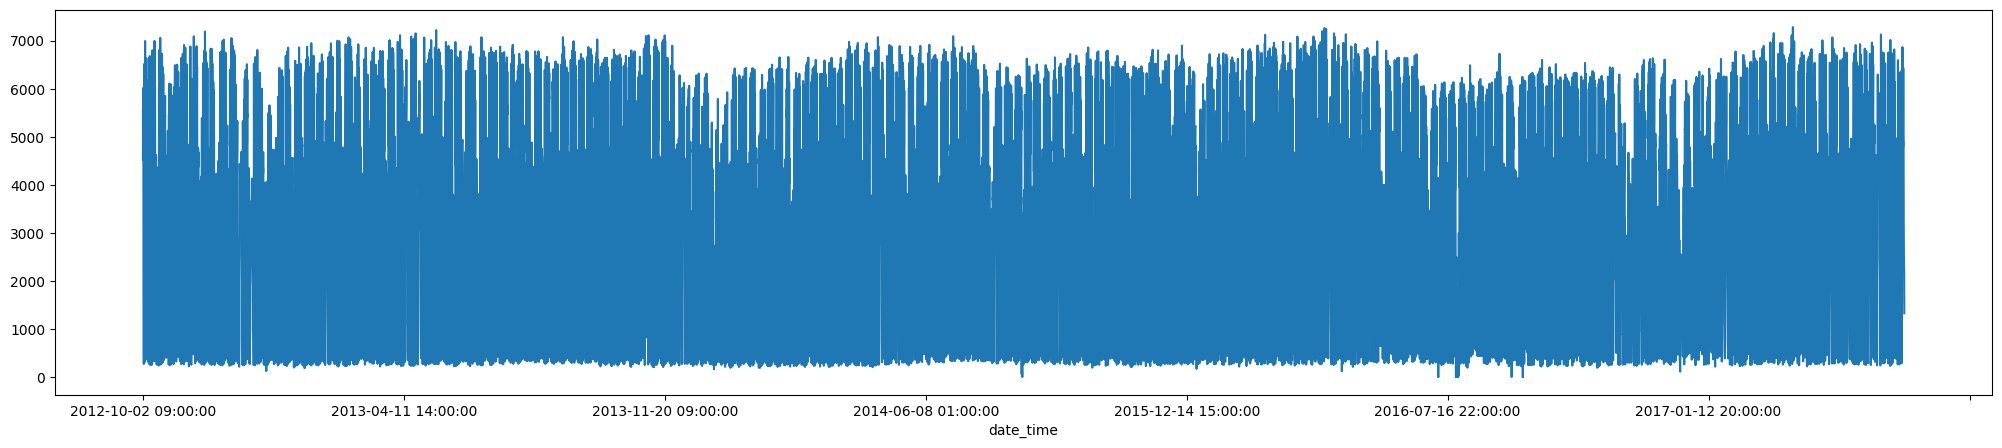

In [11]:
train['traffic_volume'].plot(figsize=(25,5))

## Data Preprocessing

For handling categorical variables **is_holiday, weather_type, weather_description,** we perform one-hot encoding

In [13]:
from tqdm import tqdm

def pre_process(data):
    data['holiday'] = 0
    for i in tqdm(range(len(data))):
        if(data.iloc[i]['is_holiday'] != "None"):
            data.iloc[i]['holiday'] = 1
    weather_type = pd.get_dummies(data['weather_type'],prefix="weather_type")
    weather_desc = pd.get_dummies(data['weather_description'],prefix="weather_desc")
    data = data.drop(['weather_type','weather_description','is_holiday'],axis=1)
    data = pd.concat([data,weather_type,weather_desc],axis=1)
    data.head()
    return(data)

In [14]:
train = pre_process(train)

100%|██████████| 33750/33750 [00:07<00:00, 4262.17it/s]


## Augmented Dickey-Fuller Test

In [15]:
t = sm.tsa.adfuller(train.traffic_volume, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -23.77966
p-value                            0.00000
#Lags Used                        48.00000
Number of Observations Used    33701.00000
dtype: float64

The results suggest that the time series data you analyzed is **likely stationary**, meaning it does not have a unit root and its statistical properties do not change over time.

## Decomposition of elements

In [16]:
s = sm.tsa.seasonal_decompose(train.traffic_volume, period=12)

<Axes: xlabel='date_time'>

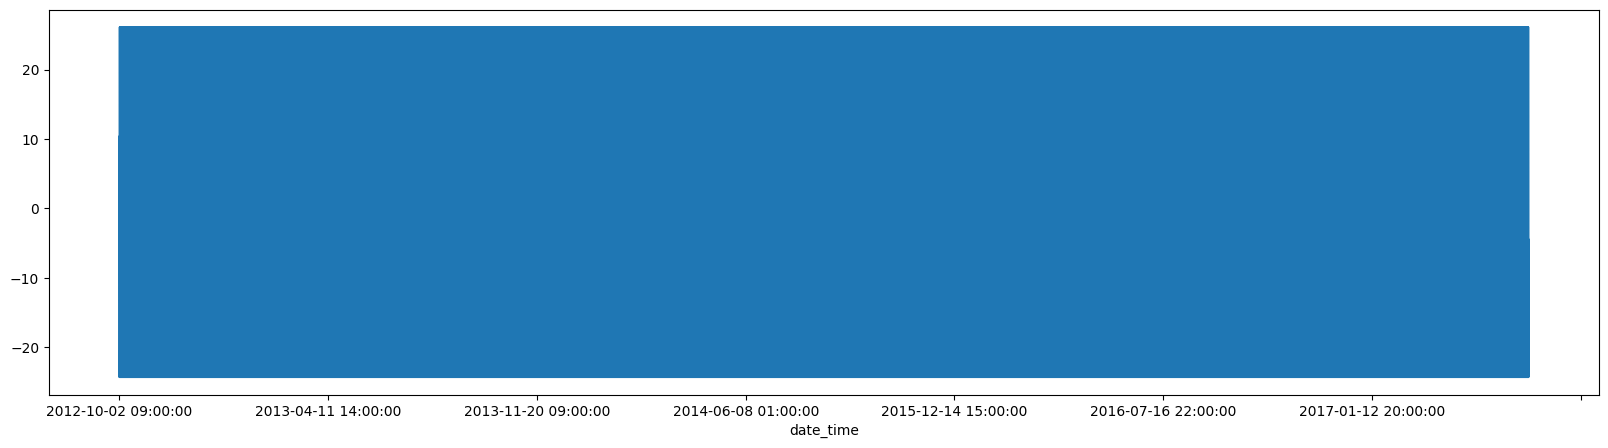

In [18]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

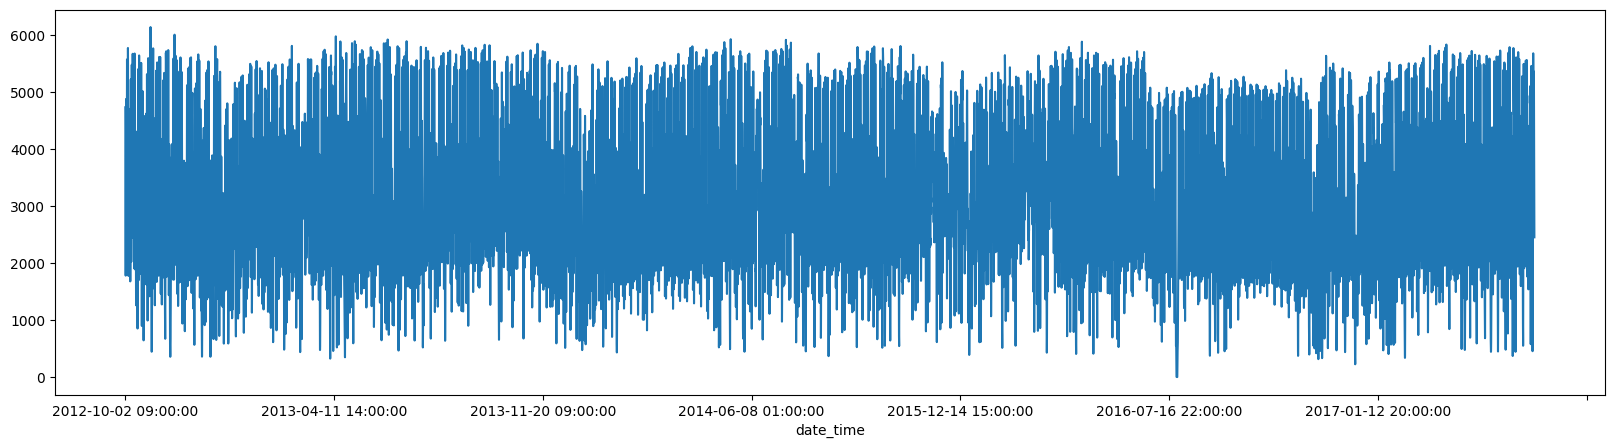

In [19]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='date_time'>

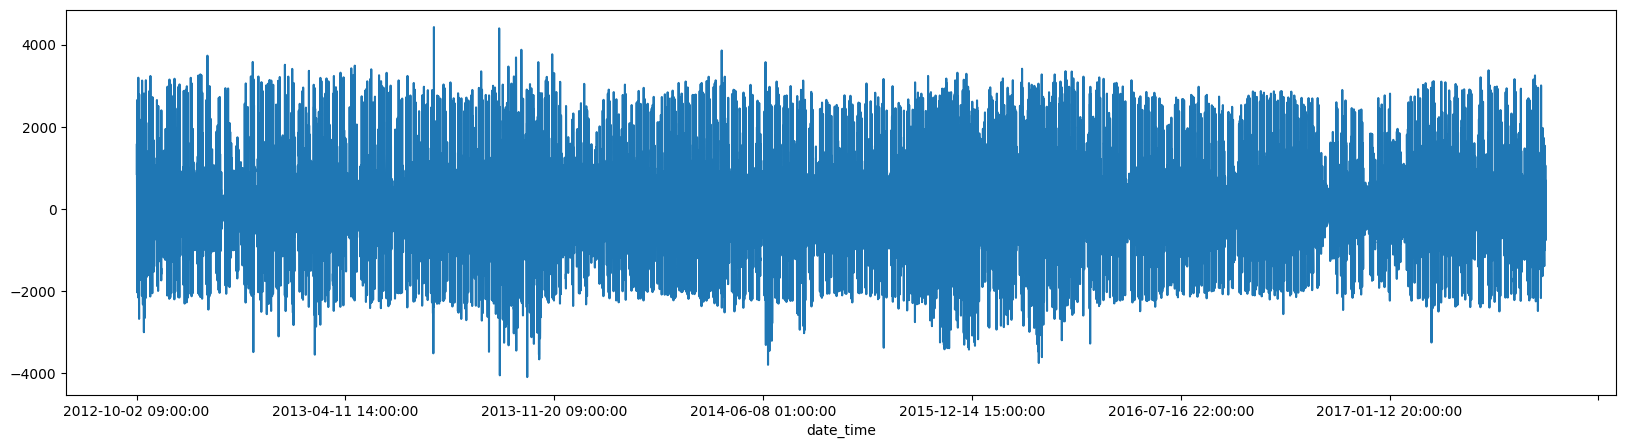

In [20]:
s.resid.plot(figsize=(20,5))

## ARIMAX Model

In [21]:
train.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'holiday',
       'weather_type_Clear', 'weather_type_Clouds', 'weather_type_Drizzle',
       'weather_type_Fog', 'weather_type_Haze', 'weather_type_Mist',
       'weather_type_Rain', 'weather_type_Smoke', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_desc_SQUALLS', 'weather_desc_Sky is Clear',
       'weather_desc_broken clouds', 'weather_desc_drizzle',
       'weather_desc_few clouds', 'weather_desc_fog',
       'weather_desc_freezing rain', 'weather_desc_haze',
       'weather_desc_heavy intensity drizzle',
       'weather_desc_heavy intensity rain', 'weather_desc_heavy snow',
       'weather_desc_light intensity drizzle',
       'weather_desc_light intensity shower rain', 'weather_desc_light rain',
       'weather_desc_light rain and snow', 

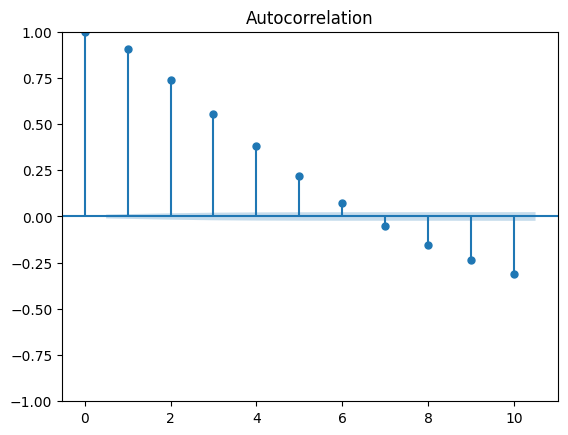

In [22]:
plot_acf(train.traffic_volume,lags=10)
plt.show()

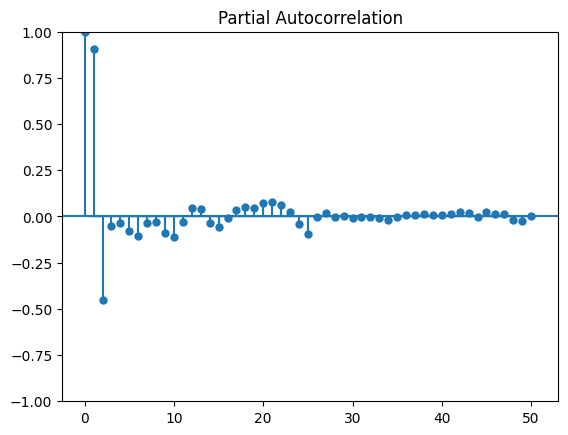

In [23]:
plot_pacf(train.traffic_volume,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model. 

The **Akaike Information Criterion (AIC)** is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

### Please dont run this code just for reference 

In [ ]:
'''
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,7)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.traffic_volume, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better
'''

### Assume  **p = 1 , d = 0, q = 1**

## Specify endogenous and exogenous variables in the data

In [24]:
# Drop the 'traffic_volume' column from the training data to create the exogenous variables dataset
exog_columns = [
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]

# Select only these columns from the DataFrame
exog_data = train[exog_columns]


# Add a constant term (intercept) to the exogenous variables dataset
exog = sm.add_constant(exog_data)

# Select the 'traffic_volume' column from the training data as the endogenous variable (target)
endog = train['traffic_volume']

In [25]:
exog.dtypes

const                  float64
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
dtype: object

In [26]:
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1))
model_fit = mod.fit()
model_fit.summary()

# Can use model_fit = mod.fit(maxiter=5) or model_fit = mod.fit(maxiter=10) if its taking too much time to run

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07429D+00    |proj g|=  5.62121D-02

At iterate    5    f=  8.07177D+00    |proj g|=  9.87528D-03

At iterate   10    f=  8.07030D+00    |proj g|=  3.12046D-03

At iterate   15    f=  8.06857D+00    |proj g|=  3.51209D-04

At iterate   20    f=  8.06851D+00    |proj g|=  4.87439D-04

At iterate   25    f=  8.06850D+00    |proj g|=  8.32368D-04

At iterate   30    f=  8.06835D+00    |proj g|=  3.45635D-04

At iterate   35    f=  8.06830D+00    |proj g|=  1.52919D-04

At iterate   40    f=  8.06830D+00    |proj g|=  2.63849D-04

At iterate   45    f=  8.06827D+00    |proj g|=  4.61303D-04

At iterate   50    f=  8.06823D+00    |proj g|=  9.83127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                33750
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -272302.723
Date:                Fri, 25 Oct 2024   AIC                         544633.445
Time:                        18:06:30   BIC                         544751.420
Sample:                             0   HQIC                        544671.088
                              - 33750                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2804.4871     97.544    -28.751      0.000   -2995.670   -2613.304
air_pollution_index    -0.0175      0.030     -0.578      0.563      -0.077       0.042
humidity                1.1466      0.590      1.944      0.052      -0.009       2.303
wind_speed             19.0366      3.174      5.999      0.000      12.817      25.257
wind_direction         -0.0891      0.059     -1.505      0.132      -0.205       0.027
visibility_in_miles    -1.0887      0.500     -2.177      0.029      -2.069      -0.109
dew_point              -1.0887      0.500     -2.177      0.029      -2.069      -0.109
temperature            21.2365      0.256     82.876      0.000      20.734      21.739
rain_p_h                0.0252      0.047      0.537      0.591      -0.067       0.117
snow_p_h              443.8983    813.901      0.545      0.585   -1151.319    2039.116
clouds_all              0.0539      0.153      0.353      0.724      -0.246       0.354
ar.L1                   0.8498      0.004    215.580      0.000       0.842       0.857
ma.L1                   0.3942      0.004    110.185      0.000       0.387       0.401
sigma2               6.131e+05   3138.255    195.370      0.000    6.07e+05    6.19e+05
===================================================================================
Ljung-Box (L1) (Q):                 151.18   Jarque-Bera (JB):             80222.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+23. Standard errors may be unstable.
"""

Question 1: Based on the provided model summary, determine the significance of each variable in the regression model. Use the p-values to classify each variable as statistically significant or not significant. Provide a brief explanation for each classification. \
Bonus if you can remove useless variables and improve the model.

In [27]:
# Significant Variables (p-value < 0.05):
# const (Intercept):

# p-value = 0.000
# Explanation: The constant term is highly significant, meaning the baseline level of the dependent variable (traffic volume) is significantly different from zero.
# wind_speed:

# p-value = 0.000
# Explanation: Wind speed is highly significant and positively associated with traffic volume, implying that an increase in wind speed influences traffic volume.
# visibility_in_miles:

# p-value = 0.029
# Explanation: Visibility is statistically significant, suggesting that lower visibility is associated with reduced traffic volume.
# dew_point:

# p-value = 0.029
# Explanation: Dew point is also significant, which indicates that humidity or temperature conditions (reflected by dew point) play a role in traffic volume.
# temperature:

# p-value = 0.000
# Explanation: Temperature is highly significant, indicating that changes in temperature have a strong effect on traffic volume.
# ar.L1 (Autoregressive term):

# p-value = 0.000
# Explanation: The AR(1) term is highly significant, indicating that the previous value of traffic volume has a strong influence on the current value.
# ma.L1 (Moving Average term):

# p-value = 0.000
# Explanation: The MA(1) term is also highly significant, meaning that the error from the previous time period influences the current traffic volume.
# sigma2 (Variance of residuals):

# p-value = 0.000
# Explanation: The residual variance (sigma squared) is significant, showing the model has significant unexplained variance, but the magnitude of the residual variance is noteworthy.
# Non-Significant Variables (p-value ≥ 0.05):
# air_pollution_index:

# p-value = 0.563
# Explanation: Air pollution index is not significant, meaning there’s no statistically significant relationship between air pollution levels and traffic volume in this model.
# humidity:

# p-value = 0.052
# Explanation: Humidity is borderline, but not significant at the 5% level. There’s weak evidence that humidity affects traffic volume, but it's not strong enough to be conclusive.
# wind_direction:

# p-value = 0.132
# Explanation: Wind direction is not significant, indicating that the direction of the wind does not significantly influence traffic volume.
# rain_p_h:

# p-value = 0.591
# Explanation: Rainfall per hour is not significant, suggesting that rain doesn’t have a statistically significant impact on traffic volume in this dataset.
# snow_p_h:

# p-value = 0.585
# Explanation: Snowfall per hour is also not significant, meaning that snowfall doesn’t show a statistically significant effect on traffic volume.
# clouds_all:

# p-value = 0.724
# Explanation: The cloud cover variable is not significant, suggesting that cloudiness does not affect traffic volume in a statistically meaningful way.

SyntaxError: invalid character '≥' (U+2265) (2178010282.py, line 34)

Plotting the predicted values on the train set - shows a decent prediction

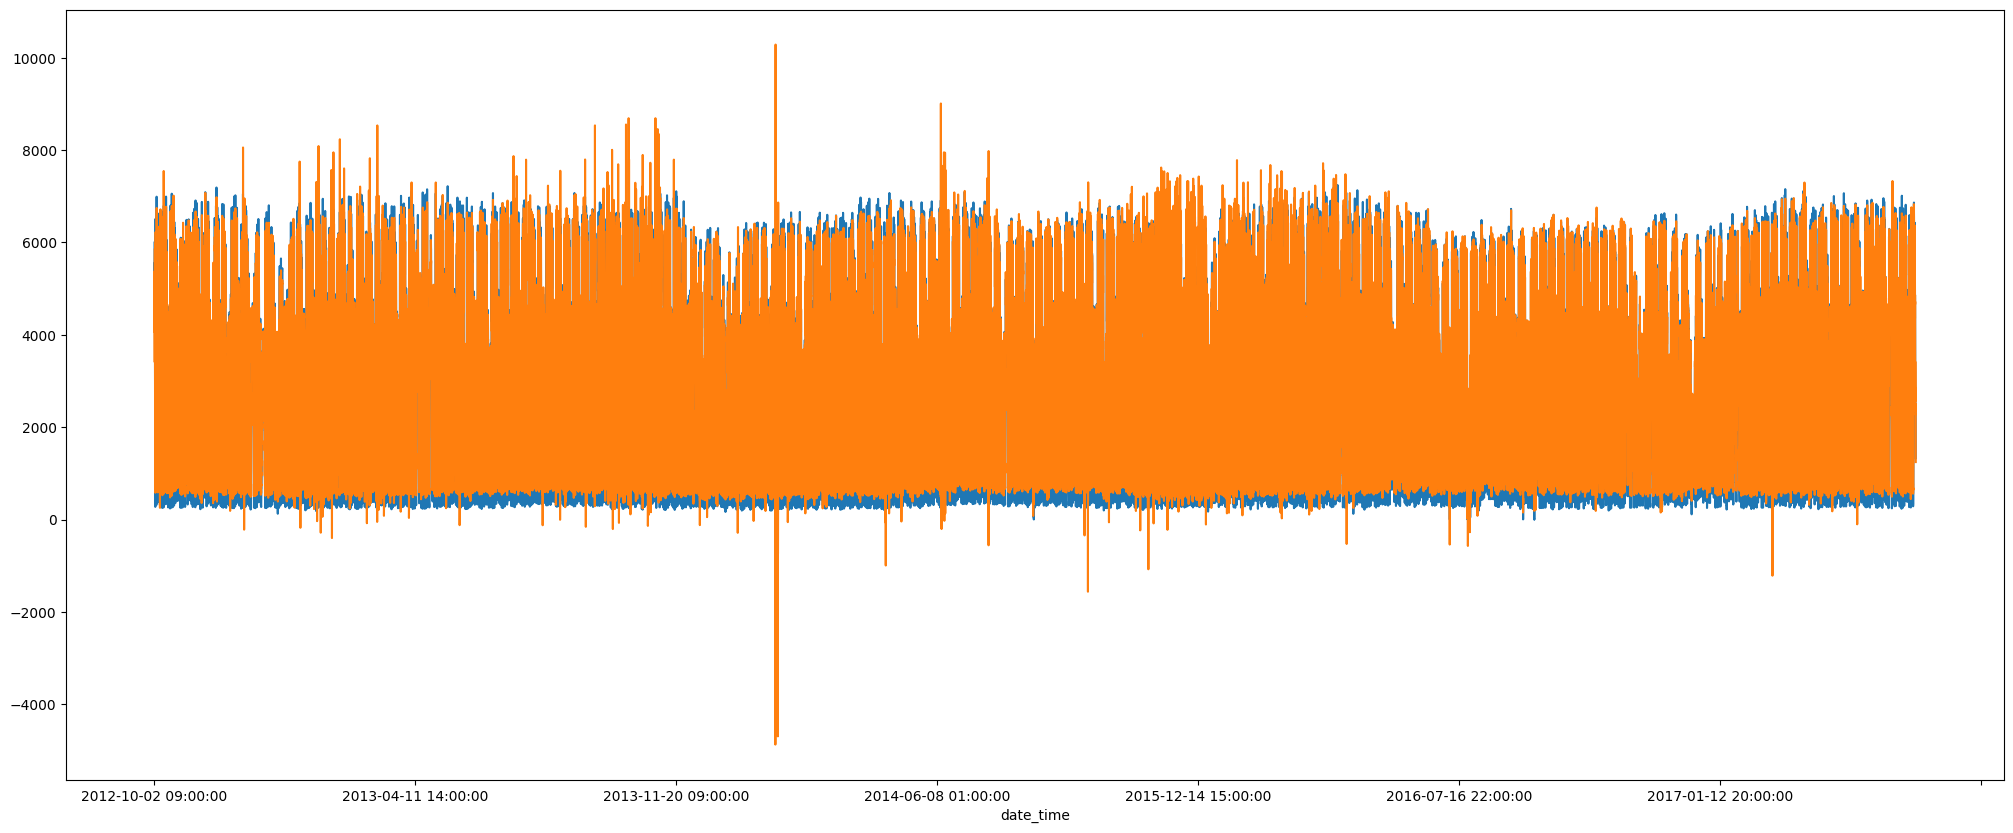

In [28]:
train['traffic_volume'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

With this piece of code, we shall perform model inference. 
We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for `traffic_volume`

In [29]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[[
    'air_pollution_index',
    'humidity',
    'wind_speed',
    'wind_direction',
    'visibility_in_miles',
    'dew_point',
    'temperature',
    'rain_p_h',
    'snow_p_h',
    'clouds_all'
]]))
test['predicted'] = predict.values
test.tail(5)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,predicted
14449,2018-09-30 19:00:00,NaN,176,21,4,345,4,4,283.45,0.0,0,75,Clouds,broken clouds,3276.751473
14450,2018-09-30 20:00:00,NaN,214,95,8,280,6,6,282.76,0.0,0,90,Clouds,overcast clouds,3424.671194
14451,2018-09-30 21:00:00,NaN,173,63,4,238,1,1,282.73,0.0,0,90,Thunderstorm,proximity thunderstorm,3326.540922
14452,2018-09-30 22:00:00,NaN,21,57,8,268,7,7,282.09,0.0,0,90,Clouds,overcast clouds,3369.134823
14453,2018-09-30 23:00:00,NaN,116,70,8,328,6,6,282.12,0.0,0,90,Clouds,overcast clouds,3379.852160


We've defined 2 metrics here - MAE and MAPE, to quantify our loss here. Can't calculate because the test data doesnt contain `traffic_volume` column

This how we will calculate it: 
* 
MAE = mean_absolute_error(test["traffic_volume"], test["predicted"]) \
RMSE = math.sqrt(mean_squared_error(test["traffic_volume"], test["predicted"])) \
print("MAE:", MAE) \
print("RMSE:", RMSE) 

 Question 2: Your task is to use the above learnings, and apply a SARIMAX model. Do reuse the code, identify a suitable seasonal order, and experiment to find the best performing model! Also, provide your reasoning for choosing your seasonal order!

> Hint: In your model definition step, you'll have to provide a `seasonal_order` parameter along with `order`. 

In [31]:
# Your answer here
import statsmodels.api as sm
import pandas as pd

# Assume df_ts contains your time series data with a traffic_volume column
exog_vars = train[['wind_speed', 'visibility_in_miles', 'dew_point', 'temperature']]  # Significant variables

# Set up SARIMAX with an initial guess for the seasonal order (experiment with different orders)
sarimax_model = sm.tsa.SARIMAX(train['traffic_volume'], 
                               order=(2, 1, 2),  # ARIMA order (p, d, q)
                               seasonal_order=(2, 1, 1, 12),  # Seasonal order (P, D, Q, S)
                               exog=exog_vars,  # External regressors
                               enforce_stationarity=False, 
                               enforce_invertibility=False)

# Fit the model
sarimax_result = sarimax_model.fit()

# Print the summary to evaluate the performance
print(sarimax_result.summary())

# Plot the diagnostics to assess model fit
sarimax_result.plot_diagnostics(figsize=(12, 8))


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26886D+00    |proj g|=  8.49017D-02


KeyboardInterrupt: 

As before, a plot ACF and PACF of differenced time series can be used to find non-seasonal orders p and q. However, to find seasonal orders P and Q we need to plot ACF and PACF of the differenced time series at multiple seasonal steps.

From the graph, P and Q can be found

Reference :\
https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/#:~:text=However%2C%20to%20find%20seasonal%20orders,series%20at%20multiple%20seasonal%20steps.&text=From%20left%20to%20right%3A,S%3D7

## LSTMs

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture in deep learning. LSTMs are designed to address the vanishing gradient problem in traditional RNNs, allowing them to effectively capture and model long-range dependencies in sequential data. They have become a crucial tool for tasks like natural language processing, time series forecasting, and sequential pattern recognition.

LSTMs are often used to effectively model complicated time-series problems, so we'll explore this further.

For the scope of this worksheet, we'll only use the target variable and it's lags as input to the LSTM. However, you're encouraged to explore how the entire input dataset can be modeled as input to the model.

Our first task would be to convert our time-series forecasting problem, into a supervised learning problem. Any ideas on how we can achieve this?

Let's first learn the distinction between a time series, and a supervised learning problem.

A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values.

A supervised learning problem comprises input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns.

Pandas has a `shift()` function, that we can use to extract **lags** from the target variable. In essence, we want to somehow bring a X->y relation with respect to the target variable, while retaining the time component.

So, what are *lags*?

Lags refer to the practice of shifting a time series data point or variable backward in time by a certain number of time units.

If you're able to understand where this is going now....

We're essentially going to create a mapping such that : 

`var(t - 1) -> var(t)`; which resembles `X -> y` !

We can go further here, and take more lags, such as `var(t - 2), var(t - 3)`, etc.!

Incase you found this prelude a little difficult to follow, consider going through a more detailed write-up here: 

[Machine Learning Mastery's Blog on converting time series to supervised learning](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Applying LSTM to our dataset

In [55]:
df = pd.read_csv("/kaggle/input/ist-traffic-and-weather-time-series-dataset/Train.csv", encoding = "unicode_escape")

In [56]:
np.random.seed(11)
dataframe = df.loc[:,'traffic_volume']
dataset = dataframe.values
dataset = dataset.astype('float32')

For this demonstration purpose, we'll use lags of 7 days, and convert it into a supervised learning problem. 

Here's a function that's borrowed from the aforementioned blog, that helps us in converting the time series to a supervised problem - 

In [57]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [58]:
new_dataset = series_to_supervised(dataset, 7,1)
new_dataset.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,5545.0,4516.0,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0
8,4516.0,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0,5791.0
9,4767.0,5026.0,4918.0,5181.0,5584.0,6015.0,5791.0,4770.0


Just to give a taste of multivariate time-series forecasting using LSTMs - we'll use `temperature` and `wind_speed` in our input to the model as well:

In [59]:
new_dataset['temperature'] = df.temperature.values[7:]
new_dataset['wind_speed']= df.wind_speed.values[7:]

In [60]:
new_dataset = new_dataset.reindex(['temperature', 'wind_speed','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
new_dataset = new_dataset.values

**Remember - we cannot use DataFrames, as LSTMs (and most other deep learning models) only accept tensors as input!**

In [61]:
type(new_dataset)

numpy.ndarray

We'll scale our features between 0 and 1 - this would be to help the process of gradient descent.

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset = scaler.fit_transform(new_dataset)

We'll split our dataset into train and test, as done for ARIMAX. Remember, it is still inherently a time series problem, so we will not use a random split.

In [63]:
train_lstm = new_dataset[:(len(new_dataset)-30), :]
test_lstm = new_dataset[(len(new_dataset)-30):len(new_dataset), :]

We adjust the labels, such that `train_X` and `test_X` contain the features, and `train_Y`, `test_Y` contain the target

In [64]:
train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

The input to a LSTM is 3D - in this format: (samples, timesteps, features). We'll go ahead and reshape our train and tests sets as such

In [65]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(33713, 1, 9) (33713,) (30, 1, 9) (30,)


## LSTM Modeling!

Epoch 1/50
469/469 - 3s - 6ms/step - loss: 0.1155
Epoch 2/50
469/469 - 1s - 2ms/step - loss: 0.0674
Epoch 3/50
469/469 - 1s - 3ms/step - loss: 0.0645
Epoch 4/50
469/469 - 1s - 2ms/step - loss: 0.0633
Epoch 5/50
469/469 - 1s - 2ms/step - loss: 0.0628
Epoch 6/50
469/469 - 1s - 2ms/step - loss: 0.0622
Epoch 7/50
469/469 - 1s - 2ms/step - loss: 0.0619
Epoch 8/50
469/469 - 1s - 2ms/step - loss: 0.0617
Epoch 9/50
469/469 - 1s - 2ms/step - loss: 0.0614
Epoch 10/50
469/469 - 1s - 2ms/step - loss: 0.0612
Epoch 11/50
469/469 - 1s - 2ms/step - loss: 0.0610
Epoch 12/50
469/469 - 1s - 2ms/step - loss: 0.0608
Epoch 13/50
469/469 - 1s - 2ms/step - loss: 0.0606
Epoch 14/50
469/469 - 1s - 2ms/step - loss: 0.0603
Epoch 15/50
469/469 - 1s - 2ms/step - loss: 0.0600
Epoch 16/50
469/469 - 1s - 2ms/step - loss: 0.0597
Epoch 17/50
469/469 - 1s - 2ms/step - loss: 0.0593
Epoch 18/50
469/469 - 1s - 2ms/step - loss: 0.0590
Epoch 19/50
469/469 - 1s - 2ms/step - loss: 0.0585
Epoch 20/50
469/469 - 1s - 2ms/step - lo

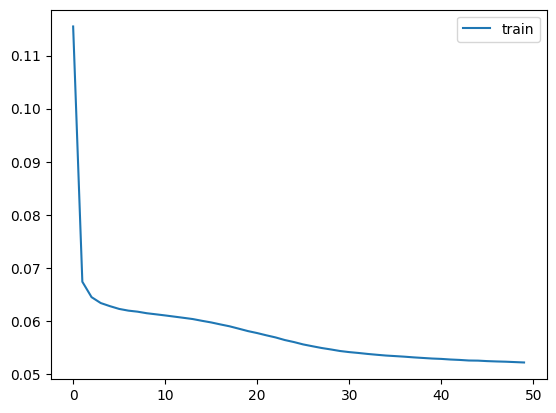

In [66]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

## LSTM Inferencing (Model Prediction)

Since we went through the whole charade of Scaling our values - making a prediction isn't completely straightforward.
We need to invert the scaling, in order to obtain the correct forecast value.

In [67]:
# make a prediction
yhat = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


In [68]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [70]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [71]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Checking the performance of the model

In [72]:
act = [i[0] for i in inv_y] # last element is the predicted power consumption
pred = [i[0] for i in inv_yhat] # last element is the actual power consumption

In [73]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(act, pred)
rmse = math.sqrt(mean_squared_error(act, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 14.64674652599948
RMSE: 21.103540604312848


Question 3: Can we use accuracy as a metric for this particular problem? Why or why not?

Accuracy isn’t a great metric to evaluate any time series model  Since accuracy is the proportion of correct predictions to total number of predictions, it isn’t advisable to use it as a metric for time 
series forecasting models.

Question 4: When can LSTMs outperform ARIMA, ARIMAX or SARIMAX models? Is it worth the computational expense to fit an LSTM over a traditional time series model?

It may be worth fitting an LSTM over a traditional time series model when:

The time series shows complex, non-linear patterns.
There are long-term dependencies or multivariate relationships.
The dataset is large and has sufficient data to train a deep learning model.
However, if the data is limited, or primarily exhibits linear relationships, using ARIMA or SARIMAX models would likely yield better performance with far less computational expense and greater interpretability. In cases where both performance and computational cost are important, hybrid models (such as using LSTMs to capture residuals from an ARIMA model) might offer a middle ground.

Question 5: What can you elucidate about the interpretability of ARIMA/ARIMAX vs LSTMs?

The interpretability of a model refers to how well a human can 
understand the decision-making process of a model. This makes it an important 
metric while choosing a model for time-series forecasting. 
Traditional regression-based time series forecasting models like ARIMA and 
ARIMAX are highly interpretable as they are based on clear statistical 
assumptions similar to regression models. 
LSTMs on the other hand aren’t as interpretable as their regression based 
counterparts as they are based on recurrent neural networks where weights 
can dynamically change and hyperparameters are tuned by the model itself 
and not by humans

Hint: Think black-box models

### Congratulations on making it to the end of the worksheet! I hope you have a much better understanding of modeling the time-series workflow, and applications of Deep Learning methods too!

### Incase you want to explore further, Facebook Prophet is a great time series model as well to have in your toolbox!
### Read more [here!](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)